In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 15})
from gradientDescent import ztheta
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GM
from sklearn.metrics import adjusted_rand_score as ARS
import itertools
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import skew, kurtosis
from scipy.stats import gaussian_kde
from scipy.spatial.distance import braycurtis as bcd

In [3]:
cow_data = np.array(pd.read_csv('data_files/data_COWS.csv', index_col=0))

In [ ]:
# cow_obj = ztheta(cow_data, 0.005, 50000, 16, True)

In [61]:
# df = pd.DataFrame(cow_obj.theta)
# df.to_csv('fig_2_files/cow_theta.csv')

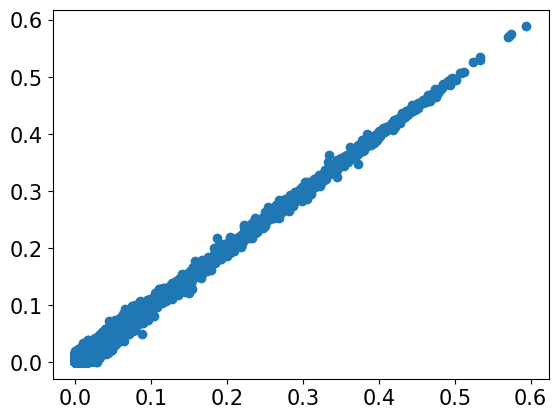

In [3]:
cow_z = np.array(pd.read_csv("fig_2_files/cow_z.csv", index_col=0))
cow_theta = np.array(pd.read_csv("fig_2_files/cow_theta.csv", index_col=0))

reconstruction = np.exp(-np.matmul(cow_z, cow_theta))
recon_sum = np.sum(reconstruction, axis=1)
reconstruction = reconstruction/recon_sum[:, np.newaxis]

plt.scatter(cow_data, reconstruction)
plt.show()

In [4]:
ris = []
for i in range(1, 5):
    predictions = []
    temp = []
    for j in range(100):
        predictions.append(GM(n_components=i).fit_predict(cow_z))
    predictions=np.array(predictions)
    combinations = list(itertools.combinations(predictions, 2))
    for combination in combinations:
        x, y = combination
        temp.append(ARS(x, y))
    ris.append(np.average(temp))

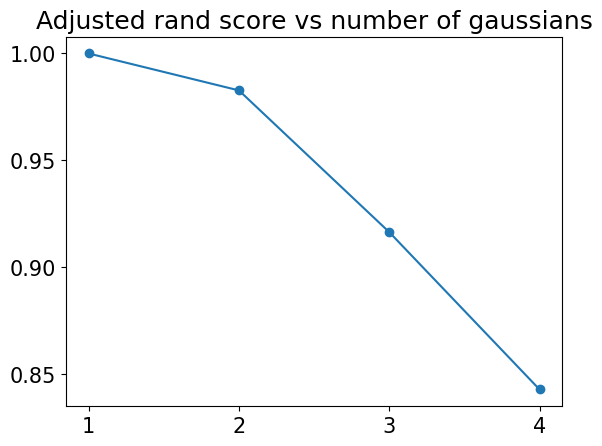

In [5]:
plt.plot(np.arange(1, 5), ris, marker="o")
plt.title("Adjusted rand score vs number of gaussians")
plt.xticks(np.arange(1,5))
plt.yticks([0.85, 0.9, 0.95, 1])
plt.show()

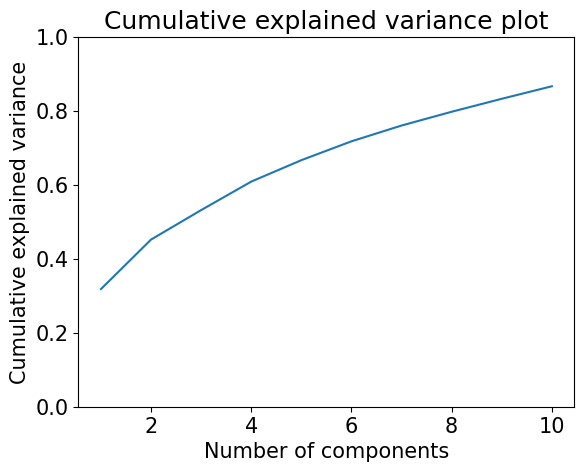

In [6]:
z_pca = PCA(n_components=10)
pca_vars = z_pca.fit_transform(cow_z)
evr_cumsum = np.cumsum(z_pca.explained_variance_ratio_)
plt.plot(np.arange(1, evr_cumsum.shape[0]+1), evr_cumsum)
plt.ylim(0,1)
plt.title("Cumulative explained variance plot")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

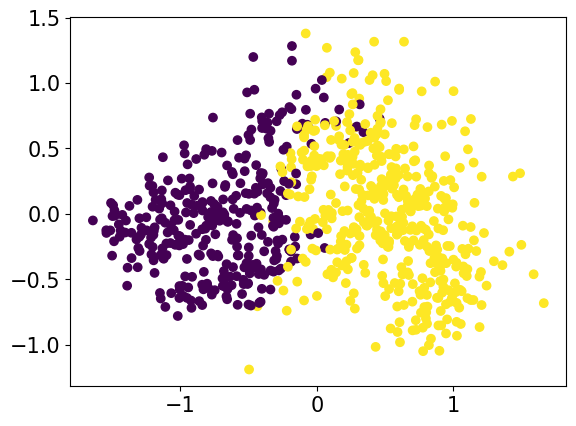

In [7]:
gm = GM(n_components=2).fit(cow_z)
final_prediction = gm.predict(cow_z)
plt.scatter(pca_vars[:, 0], pca_vars[:, 1], c=final_prediction)
plt.show()

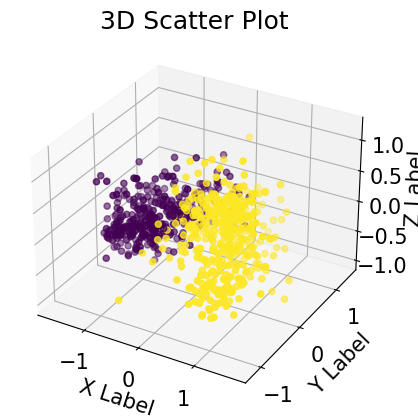

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(pca_vars[:,0], pca_vars[:,1], pca_vars[:,2], c=final_prediction)

# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()

In [9]:
best_score = -np.inf
for i in range(100):
    model = GM(n_components=2).fit(cow_z)
    score = np.mean(model.score_samples(cow_z))
    if score > best_score:
        best_score = np.copy(score)
        gm = model

z_samples, sample_labels = gm.sample(cow_data.shape[0])

sample_construction = np.exp(-np.matmul(z_samples, cow_theta))
recon_sum = np.sum(sample_construction, axis=1)
sample_construction = sample_construction/recon_sum[:, np.newaxis]

print(np.mean(gm.score_samples(cow_z)), best_score)

0.3662051783961971 0.3662051783961971


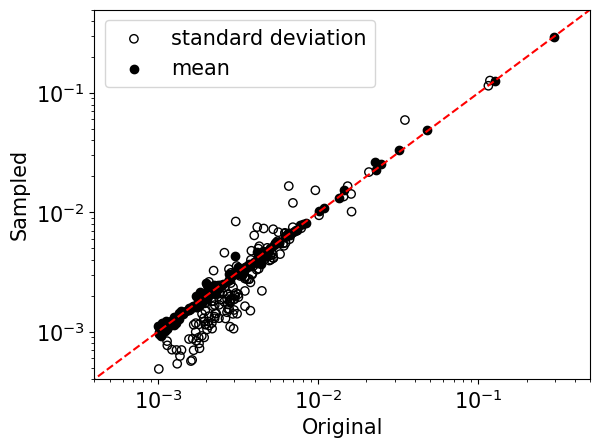

In [10]:
x = np.logspace(-4, 0, 100)

data_1_mean = np.mean(cow_data, axis=0)
data_2_mean = np.mean(sample_construction, axis=0)
data_1_std = np.std(cow_data, axis=0)
data_2_std = np.std(sample_construction, axis=0)

plt.scatter(data_1_std, data_2_std, facecolor='none', color='black', label='standard deviation')
plt.scatter(data_1_mean, data_2_mean, color='black', label='mean')
plt.plot(x, x, '--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(4e-4, 5e-1)
plt.ylim(4e-4, 5e-1)
plt.xlabel('Original')
plt.ylabel('Sampled')
plt.legend()
plt.show()

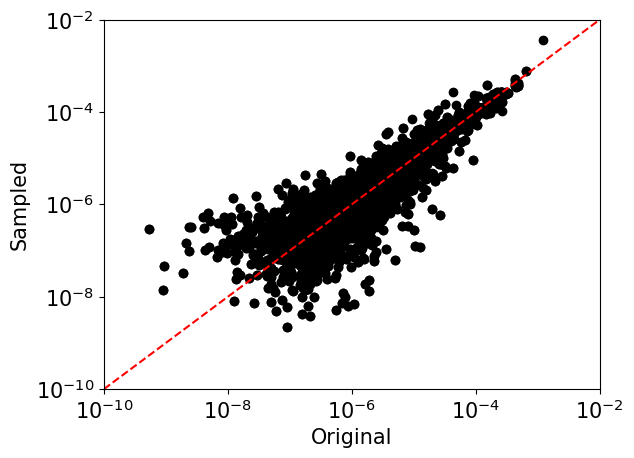

In [11]:
x = np.logspace(-10, -2, 100)

data_1_cov = np.cov(cow_data, rowvar=False)
data_2_cov = np.cov(sample_construction, rowvar=False)

plt.scatter(data_1_cov, data_2_cov, color='black')
plt.plot(x, x, '--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-10, 1e-2)
plt.ylim(1e-10, 1e-2)
plt.xlabel('Original')
plt.ylabel('Sampled')
plt.show()

In [21]:
def third_order_correlation(data):
    # Center the data
    centered_data = data - np.mean(data, axis=0)

    # Calculate the third-order covariance tensor
    n = data.shape[0]
    num_vars = data.shape[1]
    third_order_covariance = np.zeros((num_vars, num_vars, num_vars))

    for i in range(num_vars):
        for j in range(num_vars):
            for k in range(num_vars):
                third_order_covariance[i, j, k] = (1/n) * np.sum(centered_data[:, i] * centered_data[:, j] * centered_data[:, k])

    return third_order_covariance

In [22]:
data_1_third = third_order_correlation(cow_data)

In [24]:
data_2_third = third_order_correlation(sample_construction)

In [27]:
np.corrcoef(data_1_third.reshape(-1), data_2_third.reshape(-1))[0,1]

0.8914725465888924

In [12]:
z_samples, sample_labels = gm.sample(cow_data.shape[0])

sample_construction = np.exp(-np.matmul(z_samples, cow_theta))
recon_sum = np.sum(sample_construction, axis=1)
sample_construction = sample_construction/recon_sum[:, np.newaxis]

data_1_skew = skew(cow_data)
data_2_skew = skew(sample_construction)
data_1_kurt = kurtosis(cow_data)
data_2_kurt = kurtosis(sample_construction)
print(np.corrcoef(data_1_skew, data_2_skew)[0,1])
print(np.corrcoef(data_1_kurt, data_2_kurt)[0,1])

0.4275913219574836
0.31714975836187964


In [96]:
def select_equally_spaced_indices(sorted_array, num_elements):
    """
    Selects indices from a sorted array that are equally spaced in magnitude.

    Parameters:
        sorted_array (list): A sorted array.
        num_elements (int): Number of elements to select.

    Returns:
        list: List of selected indices.
    """
    array_length = len(sorted_array)
    
    # Calculate the step size
    step_size = (sorted_array[-1] - sorted_array[0]) / (num_elements - 1)
    
    # Initialize list to store selected elements
    selected_indices = []
    
    # Iterate through the array and select elements at regular intervals
    current_element = sorted_array[0]
    for _ in range(num_elements):
        # Find the closest element in the array to the current value
        closest_element = min(sorted_array, key=lambda x: abs(x - current_element))
        selected_indices.append(np.where(sorted_array == closest_element)[0][0])
        current_element += step_size
    
    return selected_indices

In [136]:
def make_inv_cummulative_abundance_plot(data, label, color):
    x_data = np.sort(np.log10(data[np.nonzero(data)]), axis=None)
    inv_cum = np.cumsum(x_data)
    inv_cum = inv_cum[-1] - inv_cum
    inv_cum = inv_cum / inv_cum[0]
    inv_cum = np.log10(inv_cum)
    idx = select_equally_spaced_indices(x_data, 70)
    plt.scatter(x_data[idx], inv_cum[idx], label=label, color=color)
    plt.title('Inverse cumulative abundance distribution')
    # plt.yscale('log')
    # plt.xlim(1e-4,1)
    plt.ylim(-4,0.2)
    plt.xlim(-4, -0.5)
    plt.xticks([-4,-3,-2,-1])


    low = min(x_data, key=lambda x: abs(x - (-2.8)))
    high = min(x_data, key=lambda x: abs(x - (-1)))
    low_idx = np.where(x_data == low)[0][0]
    high_idx = np.where(x_data == high)[0][0]

    z = np.polyfit(x_data[low_idx:high_idx], inv_cum[low_idx:high_idx], 1)
    print(z)
    p = np.poly1d(z)
    x = np.linspace(-3, -0.5, 100)
    y = p(x)
    plt.plot(x,y,'--' ,color=color)

/tmp/tmp.c8cykYGxnX/ipykernel_76795/1117807087.py:6: RuntimeWarning: divide by zero encountered in log10
  inv_cum = np.log10(inv_cum)


[-1.25306223 -3.53625907]
[-1.26645007 -3.8791613 ]


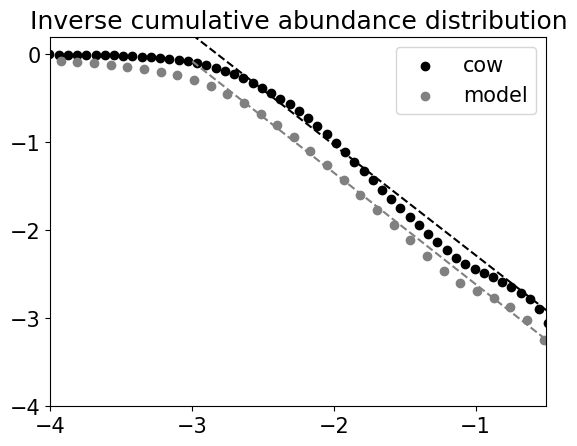

In [137]:
make_inv_cummulative_abundance_plot(cow_data, 'cow', 'black')
make_inv_cummulative_abundance_plot(sample_construction, 'model', 'grey')
plt.legend()
plt.show()

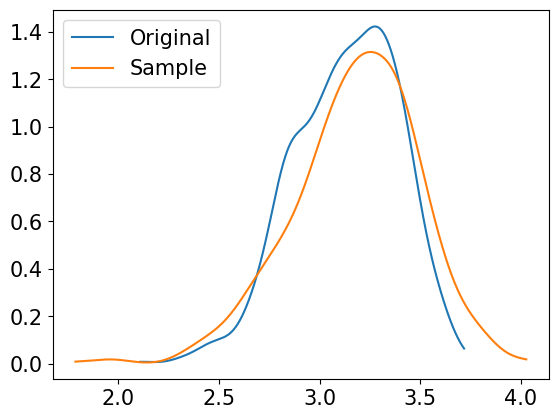

In [37]:
cow_shannon = sp.stats.entropy(cow_data, axis=1)
cow_kde = gaussian_kde(cow_shannon)
cow_x = np.linspace(min(cow_shannon), max(cow_shannon), 1000)
cow_kde_values = cow_kde(cow_x)

sample_shannon = sp.stats.entropy(sample_construction, axis=1)
sample_kde = gaussian_kde(sample_shannon)
sample_x = np.linspace(min(sample_shannon), max(sample_shannon), 1000)
sample_kde_values = sample_kde(sample_x)


plt.plot(cow_x, cow_kde_values, label='Original')
plt.plot(sample_x, sample_kde_values, label='Sample')
plt.legend()
plt.show()

In [1]:
def closest_and_random_BCD(data, label, color):
    bcd_all = []
    bcd_close = []
    idx_set = set()
    for i in range(data.shape[0]):
        if i in idx_set:  # Skip iteration if i already exists in idx_set # Might need to be deleted and instead change bcd_close.append to be conditioned on i not in set
            continue
        
        bcd_low = np.inf
        idx = None
        for j in range(i+1, data.shape[0]):
            bcd_temp = float(bcd(data[i], data[j]))
            bcd_all.append(bcd_temp)
            if bcd_temp < bcd_low and j not in idx_set:
                bcd_low = bcd_temp
                idx = j
        bcd_close.append(bcd_low)
        idx_set.add(idx)
        idx_set.add(i)

    bcd_all = np.array(bcd_all)
    bcd_close = np.array(bcd_close)
    rand_idx = np.random.choice(bcd_all.shape[0], bcd_close.shape[0], replace=False)


    close_kde = gaussian_kde(bcd_close)
    close_x = np.linspace(min(bcd_close), max(bcd_close), 1000)
    close_kde_values = close_kde(close_x)

    all_kde = gaussian_kde(bcd_all)
    all_x = np.linspace(min(bcd_all), max(bcd_all), 1000)
    all_kde_values = all_kde(all_x)


    plt.plot(close_x, close_kde_values, label='closest '+label, color=color)
    plt.plot(all_x, all_kde_values, label='all pairs '+label, color=color)


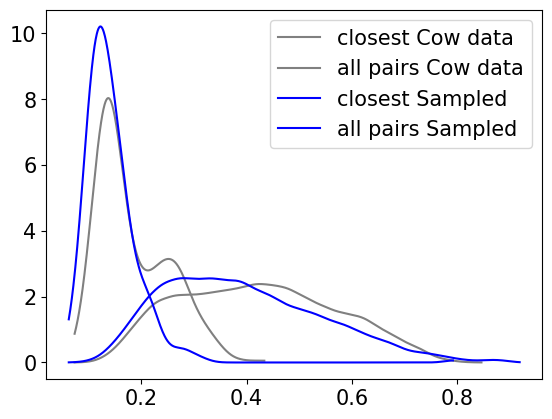

In [39]:
closest_and_random_BCD(cow_data, 'Cow data', 'grey')
closest_and_random_BCD(sample_construction, 'Sampled', 'blue')
plt.legend()
plt.show()

In [4]:
shuffled_indices = np.random.permutation(cow_data.shape[0])
train_split_idx = int(0.80 * cow_data.shape[0])
train_indices = shuffled_indices[0:train_split_idx]
test_indices = shuffled_indices[train_split_idx:]

x_train = cow_data[train_indices, :]
x_test = cow_data[test_indices, :]

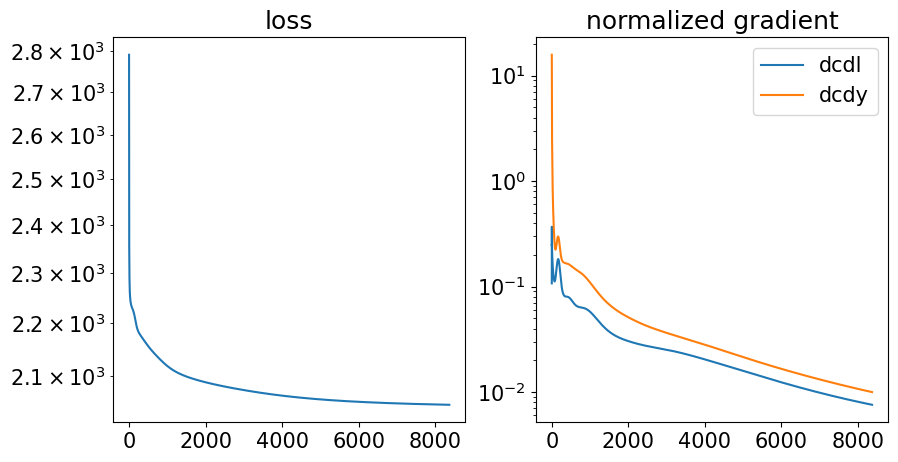

In [5]:
train_obj = ztheta(x_train, 0.005, 50000, 16, True, True)

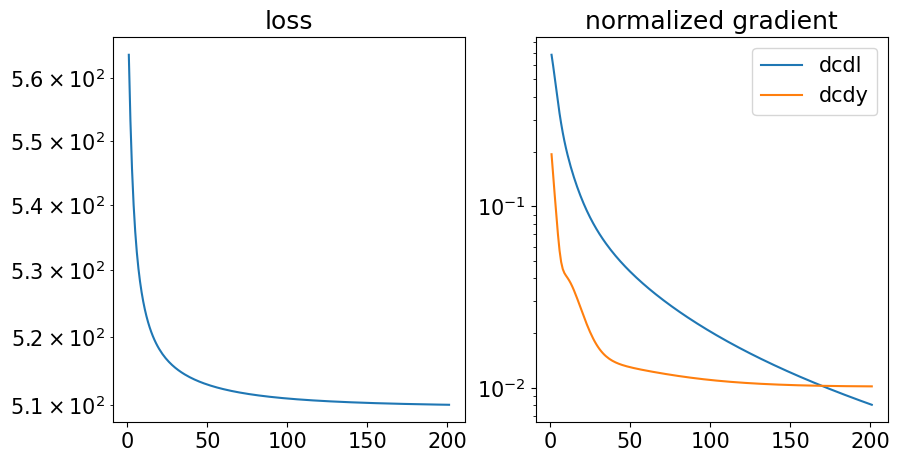

In [6]:
test_obj = ztheta(x_test, 0.1, 200, 16, True, False, train_obj.theta)

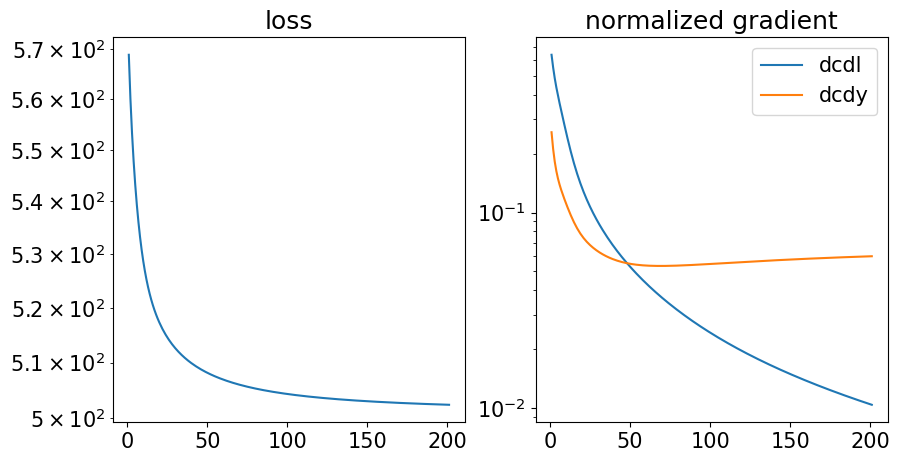

In [7]:
cow_2 = np.array(pd.read_csv('data_files/data_Cows_2.csv',index_col=0))
nordic_obj = ztheta(cow_2, 0.1, 200, 16, True, False, train_obj.theta)

In [8]:
train_reconstruction = np.exp(-np.matmul(train_obj.z, train_obj.theta))
row_sum = np.sum(train_reconstruction, axis=1)
train_reconstruction = train_reconstruction/row_sum[:, np.newaxis]

test_reconstruction = np.exp(-np.matmul(test_obj.z, test_obj.theta))
row_sum = np.sum(test_reconstruction, axis=1)
test_reconstruction = test_reconstruction/row_sum[:, np.newaxis]

nordic_reconstruction = np.exp(-np.matmul(nordic_obj.z, nordic_obj.theta))
row_sum = np.sum(nordic_reconstruction, axis=1)
nordic_reconstruction = nordic_reconstruction/row_sum[:, np.newaxis]


In [12]:
best_score = -np.inf
for i in range(100):
    model = GM(n_components=4).fit(train_obj.z)
    score = np.mean(model.score_samples(train_obj.z))
    if score > best_score:
        best_score = np.copy(score)
        gm = model
print(np.mean(gm.score_samples(train_obj.z)), best_score)

2.7018807344161173 2.7018807344161173


In [13]:
kl_train = sp.stats.entropy(x_train, train_reconstruction, axis=1)
kl_test = sp.stats.entropy(x_test, test_reconstruction, axis=1)
kl_nordic = sp.stats.entropy(cow_2, nordic_reconstruction, axis=1)

ll_train = gm.score_samples(train_obj.z)/np.log(10)
ll_test = gm.score_samples(test_obj.z)/np.log(10)
ll_nordic = gm.score_samples(nordic_obj.z)/np.log(10)


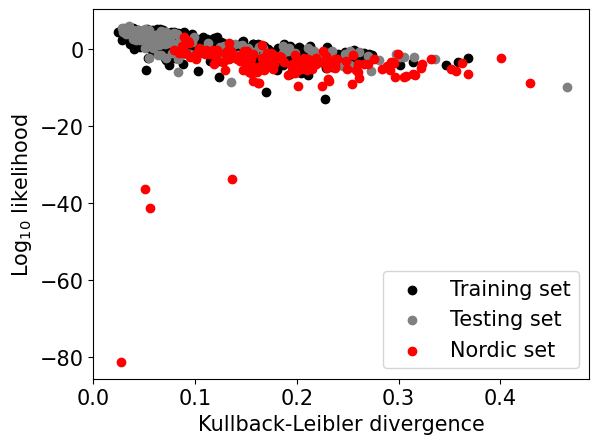

In [18]:
plt.scatter(kl_train, ll_train, color='black', label='Training set')
plt.scatter(kl_test, ll_test, color='grey', label='Testing set')
plt.scatter(kl_nordic, ll_nordic, color='red', label='Nordic set')
plt.xlabel('Kullback-Leibler divergence')
plt.ylabel(r'$\mathrm{Log}_{10}$ likelihood')
plt.xticks([0,0.1,0.2,0.3, 0.4])
# plt.ylim([-60, 20])
plt.legend()
plt.show()

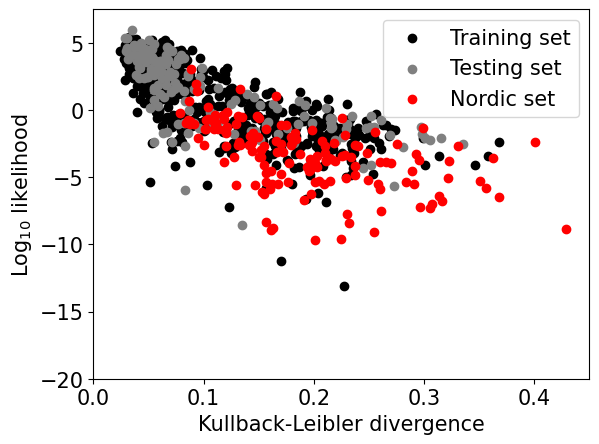

In [17]:
plt.scatter(kl_train, ll_train, color='black', label='Training set')
plt.scatter(kl_test, ll_test, color='grey', label='Testing set')
plt.scatter(kl_nordic, ll_nordic, color='red', label='Nordic set')
plt.xlabel('Kullback-Leibler divergence')
plt.ylabel(r'$\mathrm{Log}_{10}$ likelihood')
plt.xticks([0,0.1,0.2,0.3, 0.4])
plt.ylim([-20, 7.5])
plt.xlim([0, 0.45])
plt.legend()
plt.show()